In [3]:
! uv pip install lovely-jax

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"

import lovely_jax as lj

lj.monkey_patch()

import jax
from openqdc.datasets import SpiceV2 as Spice

from physnetjax.data.datasets import process_in_memory
from physnetjax.models.model import EF
from physnetjax.training.training import train_model

# Configurable Constants
NATOMS = 110
DEFAULT_DATA_KEYS = ["Z", "R", "D", "E", "F", "N"]
RANDOM_SEED = 42
BATCH_SIZE = 20

# # Environment configuration
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# JAX Configuration Check
def check_jax_configuration():
    devices = jax.local_devices()
    print("Devices:", devices)
    print("Default Backend:", jax.default_backend())
    print("All Devices:", jax.devices())


check_jax_configuration()





/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxphyscharmm/lib/python3.12/pty.py:95: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

If you really know what your doing, you can silence this warning with the warning module
or by setting POLARS_ALLOW_FORKING_THREAD=1.

  pid, fd = os.forkpty()


Using Python 3.12.5 environment at: /pchem-data/meuwly/boittier/home/miniforge3
Audited 1 package in 164ms
Devices: [CudaDevice(id=0), CudaDevice(id=1)]
Default Backend: gpu
All Devices: [CudaDevice(id=0), CudaDevice(id=1)]


In [5]:
batch_kwargs = {
    "batch_shape" : int((BATCH_SIZE - 1) * NATOMS),
    "nb_len" : int((NATOMS * (NATOMS - 1) * (BATCH_SIZE - 1)) // 1.6)
}

print(batch_kwargs)


batch_method = "advanced"
if batch_method == "advanced" and isinstance(batch_kwargs, dict) and \
    "batch_shape" in batch_kwargs and "nb_len" in batch_kwargs:
    print("Using advanced batching method")
    from physnetjax.data.batches import prepare_batches_advanced_minibatching
    def _prepare_batches(x):
        return prepare_batches_advanced_minibatching(
        x["key"],
        x["data"],
        x["batch_size"],
        batch_kwargs["batch_shape"],
        batch_kwargs["nb_len"],
        num_atoms=x["num_atoms"],
        data_keys=x["data_keys"],
    )
else:
    print("Using default batching method")
    from physnetjax.data.batches import get_prepare_batches_fn
    _prepare_batches = get_prepare_batches_fn()


prepare_spice_dataset?

{'batch_shape': 2090, 'nb_len': 142381}
Using advanced batching method
Object `prepare_spice_dataset` not found.


In [6]:
# Constants
NATOMS = 110
# total number of samples, SpiceV2 = 2008628
NTRAIN = 100000
NVALID = 500
DATA_KEYS = ("Z", "R", "E", "F", "N")
RANDOM_SEED = 42
BATCH_SIZE = 32


# Dataset preparation
def prepare_spice_dataset(
    dataset, subsample_size, max_atoms, ignore_indices=None, key=jax.random.PRNGKey(42)
):
    """Prepare the dataset by preprocessing and subsampling."""
    key = key[0] if len(key) > 1 else key
    indices = dataset.subsample(subsample_size, seed=key)
    if ignore_indices is not None:
        indices = [_ for _ in indices if _ not in ignore_indices]
    d = [dict(ds[_]) for _ in indices]
    res = process_in_memory(d, max_atoms=max_atoms, openqdc=True)
    return res, indices


ds = Spice(energy_unit="ev", distance_unit="ang", array_format="jax")
ds.read_preprocess()


# Random key initialization
data_key, train_key = jax.random.split(jax.random.PRNGKey(RANDOM_SEED), 2)


# load the validation set
validation_set, validation_set_idxs = prepare_spice_dataset(
    ds,
    subsample_size=NVALID,
    max_atoms=NATOMS,
    key=data_key,
)

# get a new data key
data_key, _ = jax.random.split(data_key, 2)
# load the training set
training_set, training_set_idxs = prepare_spice_dataset(
    ds,
    subsample_size=NTRAIN,
    max_atoms=NATOMS,
    key=data_key,
    ignore_indices=validation_set_idxs,
)


2024-12-21 21:28:03.397443: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2024-12-21 21:28:03.757 | INFO     | openqdc.datasets.base:read_preprocess:435 - Reading preprocessed data.
2024-12-21 21:28:03.758 | INFO     | openqdc.datasets.base:read_preprocess:436 - Dataset spicev2 with the following units:
                     Energy: hartree,
                     Distance: bohr,
                     Forces: hartree/bohr
2024-12-21 21:28:06.865 | INFO     | openqdc.datasets.base:read_preprocess:452 - Loaded atomic_inputs with shape (70428909, 5), dtype float32
2024-12-21 21:28:06.866 | INFO     | openqdc.datasets.base:read_preprocess:452 - Loaded position_idx_

shape: (659, 16)
┌────────────┬────────────┬────────────┬────────────┬───┬───────────┬──────────┬───────┬───────────┐
│ valid_ener ┆ valid_forc ┆ train_ener ┆ train_forc ┆ … ┆ dipole_w  ┆ forces_w ┆ epoch ┆ log       │
│ gy_mae     ┆ es_mae     ┆ gy_mae     ┆ es_mae     ┆   ┆ ---       ┆ ---      ┆ ---   ┆ ---       │
│ ---        ┆ ---        ┆ ---        ┆ ---        ┆   ┆ f64       ┆ f64      ┆ i64   ┆ str       │
│ f64        ┆ f64        ┆ f64        ┆ f64        ┆   ┆           ┆          ┆       ┆           │
╞════════════╪════════════╪════════════╪════════════╪═══╪═══════════╪══════════╪═══════╪═══════════╡
│ 7.636221   ┆ 0.182119   ┆ 7.630479   ┆ 0.205774   ┆ … ┆ 27.209999 ┆ 52.91    ┆ 0     ┆ /pchem-da │
│            ┆            ┆            ┆            ┆   ┆           ┆          ┆       ┆ ta/meuwly │
│            ┆            ┆            ┆            ┆   ┆           ┆          ┆       ┆ /boittier │
│            ┆            ┆            ┆            ┆   ┆           ┆          ┆       ┆ /ho…      │
│ 7.706049   ┆ 0.156686   ┆ 7.847248   ┆ 0.172554   ┆ … ┆ 27.209999 ┆ 52.91    ┆ 1     ┆ /pchem-da │
│            ┆            ┆            ┆            ┆   ┆           ┆          ┆       ┆ ta/meuwly │
│            ┆            ┆            ┆            ┆   ┆           ┆          ┆       ┆ /boittier │
│            ┆            ┆            ┆            ┆   ┆           ┆          ┆       ┆ /ho…      │
│ 7.754565   ┆ 0.147525   ┆ 7.801424   ┆ 0.163019   ┆ … ┆ 27.209999 ┆ 52.91    ┆ 2     ┆ /pchem-da │
│            ┆            ┆            ┆            ┆   ┆           ┆          ┆       ┆ ta/meuwly │
│            ┆            ┆            ┆            ┆   ┆           ┆          ┆       ┆ /boittier │
│            ┆            ┆            ┆            ┆   ┆           ┆          ┆       ┆ /ho…      │
│ 7.741366   ┆ 0.141425   ┆ 7.78527    ┆ 0.155017   ┆ … ┆ 27.209999 ┆ 52.91    ┆ 3     ┆ /pchem-da │
│            ┆            ┆            ┆            ┆   ┆           ┆          ┆       ┆ ta/meuwly │
│            ┆            ┆            ┆            ┆   ┆           ┆          ┆       ┆ /boittier │
│            ┆            ┆            ┆            ┆   ┆           ┆          ┆       ┆ /ho…      │
│ 7.776973   ┆ 0.137468   ┆ 7.820016   ┆ 0.150348   ┆ … ┆ 27.209999 ┆ 52.91    ┆ 4     ┆ /pchem-da │
│            ┆            ┆            ┆            ┆   ┆           ┆          ┆       ┆ ta/meuwly │
│            ┆            ┆            ┆            ┆   ┆           ┆          ┆       ┆ /boittier │
│            ┆            ┆            ┆            ┆   ┆           ┆          ┆       ┆ /ho…      │
│ …          ┆ …          ┆ …          ┆ …          ┆ … ┆ …         ┆ …        ┆ …     ┆ …         │
│ 7.981018   ┆ 0.091877   ┆ 7.998784   ┆ 0.093628   ┆ … ┆ 27.209999 ┆ 52.91    ┆ 654   ┆ /pchem-da │
│            ┆            ┆            ┆            ┆   ┆           ┆          ┆       ┆ ta/meuwly │
│            ┆            ┆            ┆            ┆   ┆           ┆          ┆       ┆ /boittier │
│            ┆            ┆            ┆            ┆   ┆           ┆          ┆       ┆ /ho…      │
│ 8.113258   ┆ 0.091319   ┆ 8.062168   ┆ 0.093562   ┆ … ┆ 27.209999 ┆ 52.91    ┆ 655   ┆ /pchem-da │
│            ┆            ┆            ┆            ┆   ┆           ┆          ┆       ┆ ta/meuwly │
│            ┆            ┆            ┆            ┆   ┆           ┆          ┆       ┆ /boittier │
│            ┆            ┆            ┆            ┆   ┆           ┆          ┆       ┆ /ho…      │
│ 8.106398   ┆ 0.091624   ┆ 8.15059    ┆ 0.093511   ┆ … ┆ 27.209999 ┆ 52.91    ┆ 656   ┆ /pchem-da │
│            ┆            ┆            ┆            ┆   ┆           ┆          ┆       ┆ ta/meuwly │
│            ┆            ┆            ┆            ┆   ┆           ┆          ┆       ┆ /boittier │
│            ┆            ┆            ┆            ┆   ┆           ┆          ┆       ┆ /ho…      │
│ 8.102584   ┆ 0.091535   ┆ 8.171932   ┆ 0.0

╭────────────────────────────────────── ~~ Log10 Loss ~~ ───────────────────────────────────────╮
│ -1.67e-01 ┤                                                                                   │
│ -1.74e-01 ┤╮╭╮                 ╭╮                                          ╭╮                 │
│ -1.81e-01 ┤╰───────────────────────────────────────────────────────────────────────────────── │
│ -1.87e-01 ┼─╯│╭───╯╰╮╭╮ ╭─╯╰╯   ╰╮│ ╰╮╭╯╰─╮╭────╯╰╯ │  ╭╮╭─╯╰─╯╰─╯╰──╯││╰╮╭╯╰─╯╰╮ ╭──────╯╰╮│ │
│ -1.94e-01 ┤  ╰╯     ╰╯╰─╯        ╰╯  ╰╯   ╰╯        ╰──╯╰╯            ╰╯ ╰╯     ╰─╯        ╰╯ │
│ -2.01e-01 ┤                                                                                   │
╰───────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────── ~~ Log10 Energy MAE ~~ ───────────────────────────────────╮
│ 9.15e-01 ┤                                                                                   │
│ 9.09e-01 ┤                    ╭╮ ╭╭─╮ ╭╮╮     ╭─╮╭╮╮    ╭╮╭╮ ╭╮╭╮╮╭╮╭╮╭╮ ╭╭─╮╭╮  ╭──╮╭╮╭──╮╭ │
│ 9.02e-01 ┤ ╭╮ ╭╭───╮╭╮╭─────────╮╭╯╰╰─╯╰──────╯╯╰╯╰─────╯╰╯╰───╯╰───╯╰────╯ ╰╯╰──╯╰╯╰──╯╯ ╰╯ │
│ 8.96e-01 ┤╭────╯   ╰╯╰╯         ╰╯                                                           │
│ 8.89e-01 ┼╯                                                                                  │
│ 8.83e-01 ┤                                                                                   │
╰──────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────── ~~ Log10 Forces MAE ~~ ────────────────────────────────────╮
│ -6.87e-01 ┤                                                                                   │
│ -7.57e-01 ┼╮                                                                                  │
│ -8.28e-01 ┤│                                                                                  │
│ -8.99e-01 ┤╰─╮───╮                                                                            │
│ -9.69e-01 ┤  ╰────────────────────────────────╮╭╮──╭╮─────────────────╮╭─╮                    │
│ -1.04e+00 ┤                                   ╰╯╰──╯╰──────────────────────────────────────── │
╰───────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── ~~ Learning Rate ~~ ─────────────────────────────────────╮
│ 1.00e-03 ┼──────╮                                                                            │
│ 8.56e-04 ┤      ╰────────────╮                                                               │
│ 7.13e-04 ┤                   ╰──────────────╮                                                │
│ 5.69e-04 ┤                                  ╰──────────────────╮                             │
│ 4.26e-04 ┤                                                     ╰──────────────────────────── │
│ 2.82e-04 ┤                                                                                   │
╰──────────────────────────────────────────────────────────────────────────────────────────────╯

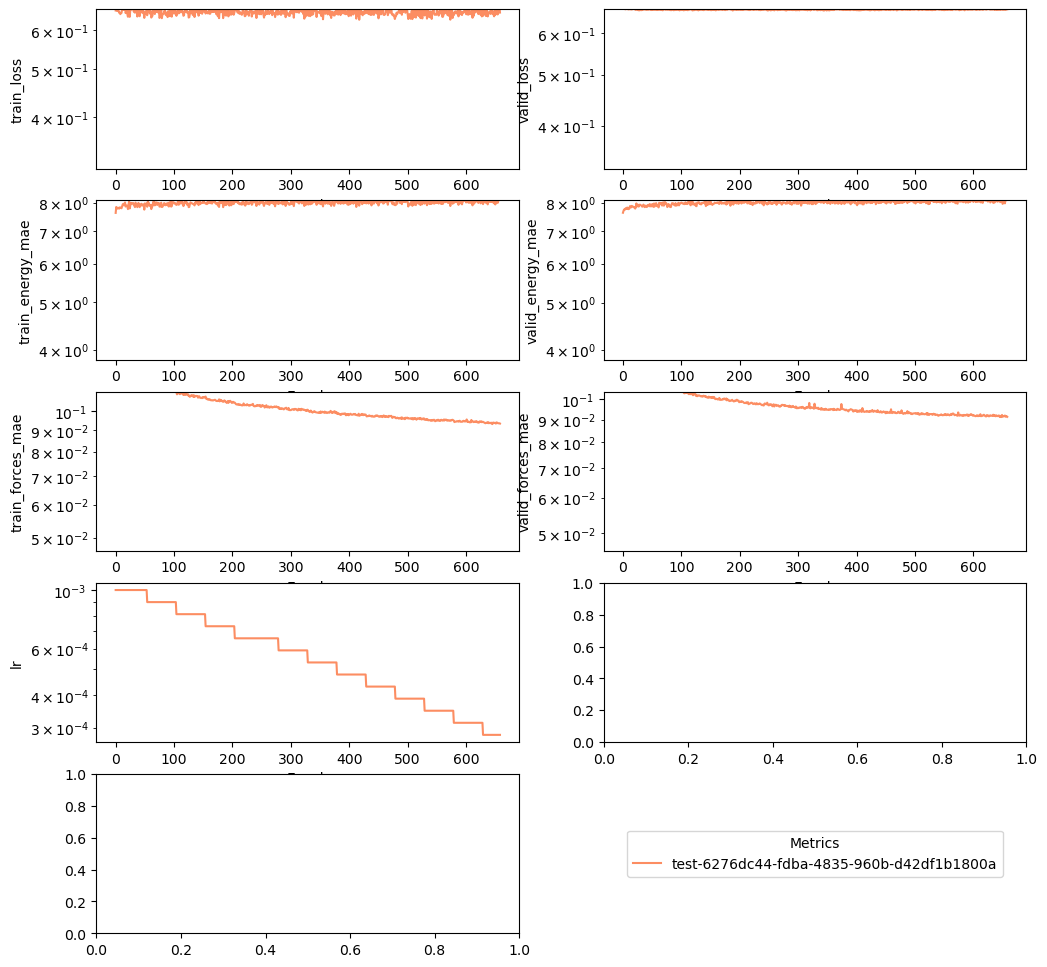

In [7]:
from argparse import ArgumentParser
from pathlib import Path
from physnetjax.analysis.plot_run import plot_run
import polars as pl
import matplotlib.pyplot as plt
from physnetjax.directories import LOGS_PATH, BASE_CKPT_DIR
from physnetjax.logger.tensorboard_interface import process_tensorboard_logs

logs_path = BASE_CKPT_DIR / "test-6276dc44-fdba-4835-960b-d42df1b1800a" / "tfevents"
key = logs_path.parent.name
df = process_tensorboard_logs(logs_path)

# pretty print polars dataframe with rich
from rich.console import Console

console = Console()
console.print(df)

fig, ax = plt.subplots(5, 2, figsize=(12, 12))
plot_run(df, ax, 1, key, log=True)
# save the plot
save_path = LOGS_PATH / key / "tf_logs.png"
# make the directory if it does not exist
save_path.parent.mkdir(exist_ok=True, parents=True)
fig.savefig(save_path, bbox_inches="tight")
# save the dataframe as a csv
df.write_csv(LOGS_PATH / key / "tf_logs.csv")


In [13]:
key, shuffle_key = jax.random.split(data_key)

kwargs = {
    "key": shuffle_key,
    "data": validation_set,
    "batch_size": BATCH_SIZE,
    "num_atoms": NATOMS,
    "data_keys": DATA_KEYS,
}


valid_batches = _prepare_batches(kwargs)


# kwargs = {
#     "key": shuffle_key,
#     "data": train_data,
#     "batch_size": batch_size,
#     "num_atoms": num_atoms,
#     "data_keys": data_keys,
# }


# train_batches = _prepare_batches(kwargs)

In [68]:
b = valid_batches[0]
b.keys()

dict_keys(['dst_idx', 'src_idx', 'batch_mask', 'Z', 'R', 'E', 'F', 'N', 'atom_mask', 'batch_segments'])

In [90]:
jax.numpy.array(b["F"]).v, b["batch_mask"]

(Array[2090, 3] n=6270 (24Kb) x∈[-0.128, 0.153] μ=-7.817e-08 σ=0.014 gpu:0
 Array([[-3.84250842e-02,  2.02695429e-02,  4.29578535e-02],
        [ 3.29913273e-02, -1.12840915e-02, -2.29609739e-02],
        [-9.15079284e-03,  4.15206450e-05, -2.39428803e-02],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],      dtype=float32),
 array([1, 1, 1, ..., 0, 0, 0]))

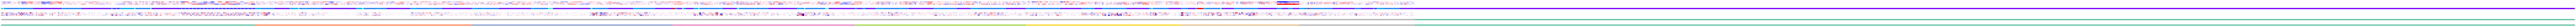

In [102]:
fig = plt.figure(figsize=(200,2.5))
n_rows = 5

ax1 = plt.subplot(n_rows, 1, 1)
ax1.matshow(b["R"].T, cmap="bwr")
ax1.set_axis_off()

ax2 = plt.subplot(n_rows, 1, 2,)
ax2.matshow(b["Z"][...,None].T, cmap="rainbow", vmin=0, vmax=35)
ax2.set_axis_off()

ax3 = plt.subplot(n_rows, 1, 3, )
ax3.matshow(b["F"].T, cmap="bwr", vmin=-0.1, vmax=0.1)
ax3.set_axis_off()

ax4 = plt.subplot(n_rows, 1, 4,)
ax4.matshow(b["atom_mask"][None,...], cmap="Set2")
ax4.set_axis_off()

ax5 = plt.subplot(n_rows, 1, 5,)
ax5.matshow(b["batch_segments"][None,...], cmap="Set2")
ax5.set_axis_off()

plt.tight_layout()
plt.show()

In [103]:
from physnetjax.restart.restart import get_last

restart = BASE_CKPT_DIR / "test-6276dc44-fdba-4835-960b-d42df1b1800a" 
restart = get_last(restart)
restart

Path('/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/test-6276dc44-fdba-4835-960b-d42df1b1800a/epoch-249')

In [104]:
from physnetjax.restart.restart import get_params_model

params, model = get_params_model(restart, natoms=110)

/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxphyscharmm/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ False  │ 5.0    │ False │ False │ 128    │ 70     │ 0      │ 2     │ 110    │ 16     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                 ┃ name      ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharmm… │ epoch-249 │ 249   │ Array gpu:0 0.663 │ 2024-12-21 04:26:13.757444 │
└────────────────────────────────────────────┴───────────┴───────┴───────────────────┴────────────────────────────┘

EF(
    # attributes
    features = 128
    max_degree = 0
    num_iterations = 5
    num_basis_functions = 16
    cutoff = 5.0
    max_atomic_number = 70
    charges = False
    natoms = 110
    total_charge = 0
    n_res = 2
    zbl = False
    debug = False
    efa = False
)


15it [00:29,  1.97s/it]


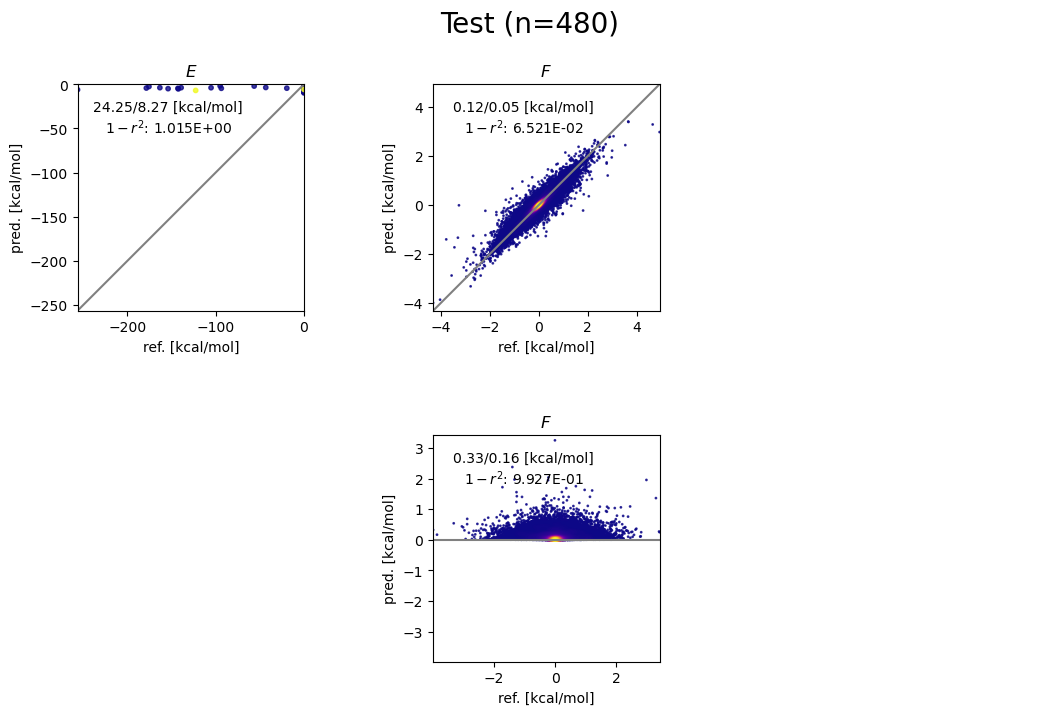

In [109]:
model.natoms = NATOMS
print(model)
from physnetjax.analysis.analysis import plot_stats
output = plot_stats(valid_batches, model, params, _set="Test", 
               do_kde=True, batch_size=BATCH_SIZE)


In [110]:
import numpy as np
energies = np.array([_["E"] for _ in valid_batches])

(array([[ 49,  40,   7, 110,  28,  54,  44,  50,  48,  48,  35,  32,  17,
          35,  49,  47,  17,  47,  30,  45,  45,  17,  38,  26,  12,  31,
          35,  18,   6,  39,  18,  31],
        [ 25,  38,  45,  37,  41,  16,  49,  70,  28,  46,  36,  55,  43,
          55,   5,  32,  16,  40,  26,  39,  30,  22,  26,  48,  43,  10,
          67,  36,   4,  41,  50,  16],
        [ 31,  50,  49,  35,  46,  41,  65,  62,  40,  45,  26,  48,  48,
          50,  39,  38,  45,  47,  34,  18,  21,  43,  39,  12,  36,  28,
          21,  44,  33,   8,  47,  24],
        [ 21,  41,  38,  43,  57,  41,  42,  49,  35,  29,  54,  39,  27,
          59,  27,  15,  21,  35,  50,  16,  41,  18,   4,  24,  49,  50,
          36,  60,  22,  20,  22,  39],
        [ 15,  17,  47,  46,   6,  61,  49,  42,  94,  30,  22,  50,  50,
          22,  41,  47,  30,  50,  27,  37,  14,  36,  28,  47,  33,  50,
          16,   9,  49,  17,  41,  14],
        [ 20,  38,  38,  41,  34,  39,  89,  28,  22,  54, 1

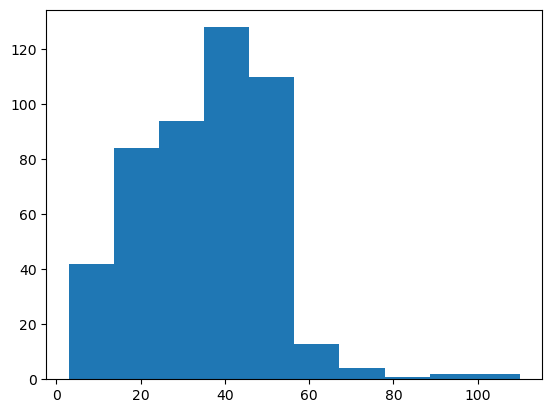

In [111]:
ns = np.vstack([_["N"] for _ in valid_batches])
nonzero = np.nonzero(ns.flatten())[0]
plt.hist(ns.flatten()[nonzero])
ns, energies

In [12]:
# plt.hist(output2["E"])
# ds._e0s_dispatcher[output2["Z"][0]]
print(ds[0]["energies"], 512.6264  * 0.0367492929)
print(ds[0]["energies"] - ds[0]["e0"].sum() * 0.0367492929  )
print(ds[0]["e0"].sum() - 512.6264 )
print(ds[0])
ds[0]["e0"].sum() * 0.0367492929, [np.array([ds._e0s_dispatcher[int(_)].mean for _ in ds[0]["atomic_numbers"] if _ != 0]).sum() ]

Array[1] gpu:0 [-1.302e+03] 18.83865772187256
Array[1] gpu:0 [-11.015]
Array gpu:0 -3.565e+04
{'positions': Array[66, 3] n=198 x∈[-15.639, 16.858] μ=1.927e-08 σ=6.309 gpu:0, 'atomic_numbers': Array[66] i32 x∈[1, 8] μ=3.348 σ=2.683 gpu:0, 'charges': Array[66] i32 x∈[0, 1] μ=0.015 σ=0.122 gpu:0, 'e0': Array[66, 1] x∈[-2.044e+03, -13.572] μ=-532.357 σ=617.590 gpu:0, 'energies': Array[1] gpu:0 [-1.302e+03], 'formation_energies': Array[1] gpu:0 [3.383e+04], 'per_atom_formation_energies': Array[1] gpu:0 [512.626], 'name': np.str_('[O:1]=[C:3]([N:16]([C@@:29]([C:4](=[O:2])[N:13]([C:19]([H:47])([H:48])[H:49])[H:37])([C:28]([C:26]([C:20]([N:14]([C:5]([N:12]([H:35])[H:36])=[N+:17]([H:42])[H:43])[H:38])([H:50])[H:51])([H:62])[H:63])([H:64])[H:65])[H:66])[H:41])[C:18]([H:44])([H:45])[H:46].[c:6]1([H:30])[c:7]([H:31])[c:9]([H:33])[c:11]([C:27]2([C:21]([N:15]([H:39])[H:40])([H:52])[H:53])[C:24]([H:58])([H:59])[C:22]([H:54])([H:55])[C:23]([H:56])([H:57])[C:25]2([H:60])[H:61])[c:10]([H:34])[c:8]1[H:32

(Array gpu:0 -1.291e+03, [np.float32(-1291.746)])

In [13]:
forces = np.vstack([_["F"] for _ in valid_batches])
nonzero = np.nonzero(forces.flatten())[0]
plt.hist(forces.flatten()[nonzero])
# forces

NameError: name 'valid_batches' is not defined

In [ ]:
from physnetjax.utils import get_last, get_files, get_params_model
from physnetjax.analysis import plot_stats
NATOMS = 110
model.natoms = NATOMS

output = plot_stats(combined, model, params, _set="Test", 
               do_kde=True, batch_size=batch_size)

# Example training

In [1]:
# Model initialization
model = EF(
    features=128,
    max_degree=0,
    num_iterations=5,
    num_basis_functions=16,
    cutoff=5.0,
    max_atomic_number=70,
    charges=False,
    natoms=NATOMS,
    total_charge=0,
    n_res=2,
    zbl=False,
)


# Model training
params = train_model(
    train_key,
    model,
    output1,
    output2,
    num_epochs= int(10**2),
    learning_rate=0.001,
    energy_weight=1,
    schedule_fn="constant",
    optimizer="amsgrad",
    batch_size=BATCH_SIZE,
    num_atoms=NATOMS,
    data_keys=DEFAULT_DATA_KEYS,
    print_freq=1,
    objective="valid_loss",
    best=1e6,
    batch_method="advanced",
    batch_args_dict=batch_kwargs,
)

NameError: name 'EF' is not defined